# First Part

Imports

In [18]:
import warnings
warnings.filterwarnings("ignore")

import os
import yaml
import numpy as np
from mne.io import *
import matplotlib.pyplot as plt

from preprocess import *
import utils

Configuration

In [12]:
with open("config/config.yml", "r") as file: config = yaml.safe_load(file)    
sfreq = config["hyperparameters"]["sfreq"]
tr = config["hyperparameters"]["tr"]

Paths

In [13]:
data_dir = os.path.join(config["paths"]["dataset_dir"], config["paths"]["subject_dir"])
eeg_outside_path = os.path.join(data_dir, config["paths"]["eeg_outside"])
eeg_inside_path = os.path.join(data_dir, config["paths"]["eeg_inside"])
spike_timing_path = os.path.join(data_dir, config["paths"]["spike_timinmg"])
os.makedirs('results', exist_ok=True)

Electrodes Postions

In [14]:
electrode_positions = config["electrode_positions_10-10"] # 'electrode_positions_10-20' to limit to 19 electrodes
electrode_labels = list(electrode_positions.keys())
electrode_positions_used = {label: electrode_positions[label] for label in electrode_labels}

EEG Data

In [5]:
'''
Documentation: https://mne.tools/stable/generated/mne.io.read_raw.html

mne.io.read_raw_brainvision   For Brain Vision Recorder .eeg files
mne.io.read_raw_eeglab        For EEGLAB .set and optional .fdt files
mne.io.read_raw_edf           For .edf and .bdf formats
mne.io.read_raw_fif           For Native file format in Neuromag/Elekta/MEGIN systems
mne.io.read_raw_eegitab       For ITAB systems
mne.io.read_raw_nihon         For Nihon Kohden EEG files
mne.io.read_raw_gdf           For General-purpose physiological data format
mne.io.read_raw_cnt           For NeuroScan systems
mne.io.read_raw_egi           For older .egi files
mne.io.read_raw_mff           For .mff files used in EGI's later systems
mne.io.read_raw_nwb           For neuroscience open format data sharing
mne.io.read_raw_kit           For MEG data from KIT/Yokogawa systems
mne.io.read_raw_ctf           For Data from CTF systems
mne.io.read_raw_artemis123    For Data from Artemis123 system
mne.io.read_raw_eximia        For Near-Infrared Spectroscopy data
mne.io.read_raw_persyst       For Persyst EEG files
mne.io.read_raw_nicolet       For EEG data from Nicolet systems
mne.io.read_raw_fieldtrip     For real-time data using FieldTrip

'''

"\nDocumentation: https://mne.tools/stable/generated/mne.io.read_raw.html\n\nmne.io.read_raw_brainvision   For Brain Vision Recorder .eeg files\nmne.io.read_raw_eeglab        For EEGLAB .set and optional .fdt files\nmne.io.read_raw_edf           For .edf and .bdf formats\nmne.io.read_raw_fif           For Native file format in Neuromag/Elekta/MEGIN systems\nmne.io.read_raw_eegitab       For ITAB systems\nmne.io.read_raw_nihon         For Nihon Kohden EEG files\nmne.io.read_raw_gdf           For General-purpose physiological data format\nmne.io.read_raw_cnt           For NeuroScan systems\nmne.io.read_raw_egi           For older .egi files\nmne.io.read_raw_mff           For .mff files used in EGI's later systems\nmne.io.read_raw_nwb           For neuroscience open format data sharing\nmne.io.read_raw_kit           For MEG data from KIT/Yokogawa systems\nmne.io.read_raw_ctf           For Data from CTF systems\nmne.io.read_raw_artemis123    For Data from Artemis123 system\nmne.io.read_raw

In [15]:
eeg_outside = read_raw_eeglab(eeg_outside_path, preload=True)
eeg_outside.pick_channels(electrode_labels)
eeg_outside_data = eeg_outside.get_data()
n_channels, n_samples = eeg_outside_data.shape
print(eeg_outside.info)
# eeg_outside.plot(scalings='auto', title="Raw EEG")

Reading D:\Datasets\Github\sample_eeg\sub01\preprocessed\outside_preprocessed.fdt
Reading 0 ... 107869  =      0.000 ...   431.476 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 250.0 Hz
>


Outside Scanner IEDs timing

In [16]:
spike_timing = (np.loadtxt(spike_timing_path, dtype=float) * sfreq).astype('int')

Preprocess EEG (outside scanner)

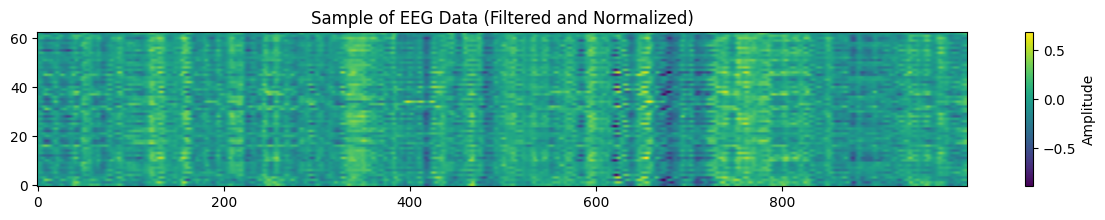

In [17]:
eeg_outside_filtered = preprocess_eeg(eeg_outside_data, sfreq=250)

plt.figure(figsize=(15, 2))
plt.title("Sample of EEG Data (Filtered and Normalized)")
plt.imshow(eeg_outside_filtered[:,:1000], aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Amplitude')
plt.savefig("results/eeg_outside.png", dpi=300, bbox_inches='tight')
plt.show()

Activity Map with Topography

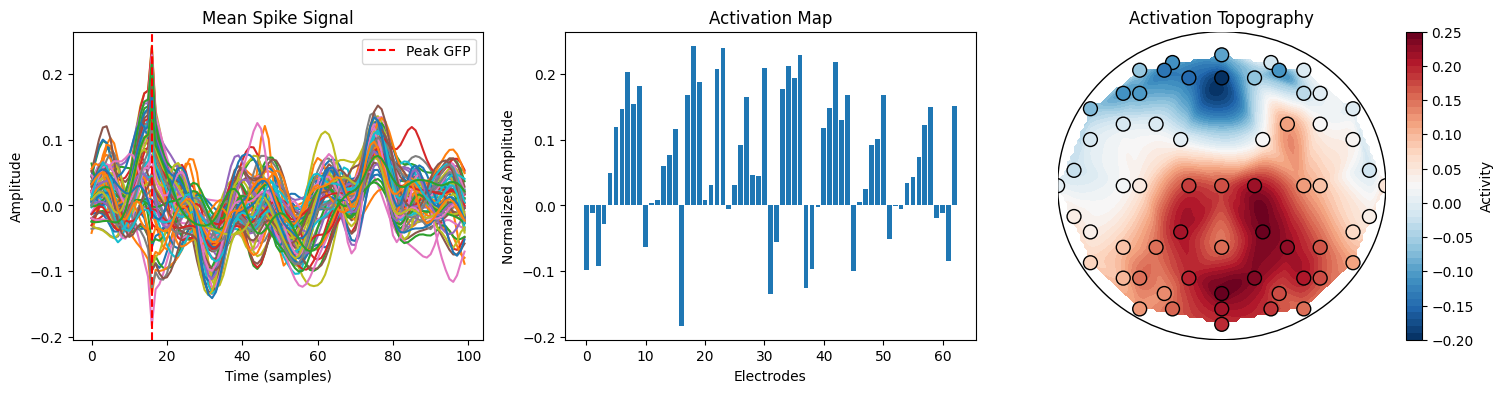

In [20]:
epileptic_map, mean_spike, gfp, peak_idx = utils.activity_map(eeg_outside_filtered, spike_timing)

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.title("Mean Spike Signal")
plt.plot(mean_spike.T)
plt.axvline(x=peak_idx, color='r', linestyle='--', label='Peak GFP')
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Activation Map")
plt.bar(range(len(epileptic_map)), epileptic_map)
plt.xlabel("Electrodes")
plt.ylabel("Normalized Amplitude")

plt.subplot(1, 3, 3)
epileptic_topography = utils.generate_topography(epileptic_map, electrode_positions_used)

plt.savefig(f"results/spike_map_{n_channels}ch.png", dpi=300, bbox_inches='tight')
plt.show()

# Second Part

| ID                                                 | What you get                                                                                                                                                                                                                            | Why it works with your script                                                                    |
| -------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------ |
| **ds003029 – Neural Fragility multi-centre study** | 100 surgical epilepsy patients from four US centres; ECoG + SEEG; BrainVision `.vhdr` snapshots around seizures; each subject folder holds `*_electrodes.tsv` (MNI m) and postoperative T1 MRI (NIfTI) ([raw.githubusercontent.com][1]) | Same formats your code expects; large sample to experiment with seizure vs. inter-ictal windows. |
| **ds003848 – RESPect**                             | 12 Utrecht patients (acute ECoG + long-term SEEG); recordings and coordinates organised per BIDS; clear README documents intra-op vs. long-term sessions ([raw.githubusercontent.com][2])                                               | Smaller, easier first download; contains both grid and depth electrodes for quick montage tests. |
| **IEEG.org portal** (many collections)             | Web API streaming of hundreds of clinical SEEG sessions; MATLAB/Python toolboxes supplied ([main.ieeg.org][3])                                                                                                                          | Good fallback if you want raw EDF only; you will have to create your own coordinate CSV.         |

[1]: https://raw.githubusercontent.com/OpenNeuroDatasets/ds003029/master/README "raw.githubusercontent.com"
[2]: https://raw.githubusercontent.com/OpenNeuroDatasets/ds003848/master/README "raw.githubusercontent.com"
[3]: https://main.ieeg.org/?utm_source=chatgpt.com "International Epilepsy Electrophysiology Portal"


In [ ]:
# %pip install openneuro-py         # lightweight Python CLI :contentReference[oaicite:3]{index=3}
# %pip install datalad              # heavy-duty git-annex client :contentReference[oaicite:4]{index=4}

In [ ]:
%cd d:\\Datasets\\Github\\sample_ieeg

# downloads into ./dataset/ds003848/sub-RESP0521
! openneuro-py download --dataset=ds003848 --include=sub-RESP0521

# # same idea with datalad:
# ! datalad install https://openneuro.org/datasets/ds003848
# ! datalad get ./dataset/ds003848/sub-RESP0521

%cd c:\\Users\\Mostafa\\OneDrive\\Documents\\Github\\epimage\\eeg

In [5]:
import pandas as pd
import pathlib as pl
from esi import estimate_sources_ieeg

In [6]:
IEEG = 'ds003848/sub-RESP0521/ses-1/ieeg/sub-RESP0521_ses-1_task-rest_run-01_ieeg.vhdr'
tsv = pl.Path(IEEG).with_suffix('').parent/'sub-RESP0521_ses-1_electrodes.tsv'
ELECTRODES = pd.read_csv(tsv, sep='\t')[['name','x','y','z']]
MRI = 'ds00848/sub-RESP0521/ses-1/anat/sub-RESP0521_ses-1_T1w.nii.gz' # (Optional)

In [7]:
ELECTRODES

,name,x,y,z
0,C01,-34.869019,-40.517885,36.584488
1,C02,-37.869019,-34.517884,43.584488
2,C03,-41.869019,-27.517883,49.584488
3,C04,-45.869019,-20.517882,58.584488
4,C05,-48.869019,-13.517882,65.584488
...,...,...,...,...
128,el128,NaN,NaN,NaN
129,thor+,NaN,NaN,NaN
130,abdo+,NaN,NaN,NaN
131,xyz+,NaN,NaN,NaN


In [ ]:
estimate_sources_ieeg(
    raw=IEEG,
    electrode_locs=ELECTRODES,
    mri_path=MRI,
    time_window=(0, 30),
    inverse_method="dSPM",
    snr=3.0,
    spacing="10",
    subjects_dir='results/sub-RESP0521_zmap.nii.gz',
    verbose=False,
    )